In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [2]:

# ==========================================
# 1. Data Loading & Preprocessing
# ==========================================
df = pd.read_csv('ORB04_EUR_EPHIO.csv')

# Inputs: X, Y, Z coordinates
X_raw = df[['X', 'Y', 'Z']].values
# Outputs: Magnetic Field Bx, By, Bz
y_raw = df[['BX', 'BY', 'BZ']].values

# Scale data to [-1, 1] for Tanh stability and easier gradient flow
input_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler = MinMaxScaler(feature_range=(-1, 1))

X_scaled = input_scaler.fit_transform(X_raw)
y_scaled = output_scaler.fit_transform(y_raw)

# Convert to Tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

# Split Training/Validation
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)


In [3]:

# ==========================================
# 2. Define the PINN Model
# ==========================================
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Standard MLP architecture
        self.net = nn.Sequential(
            nn.Linear(3, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 40),
            nn.Tanh(),
            nn.Linear(40, 3)  # Output: Bx, By, Bz
        )

    def forward(self, x):
        return self.net(x)


In [ ]:

# ==========================================
# 3. The Physics Loss (The Core of PINN)
# ==========================================
def physics_loss_function(model, x_collocation):
    """
    Calculates the residuals of Maxwell's equations at random points.
    """
    # Enable gradient tracking for the input coordinates (required for derivative)
    x_collocation.requires_grad = True

    # Predict B-field at these random points
    b_pred = model(x_collocation)

    # Separate components
    bx = b_pred[:, 0].unsqueeze(1)
    by = b_pred[:, 1].unsqueeze(1)
    bz = b_pred[:, 2].unsqueeze(1)

    # --- Compute Gradients (Automatic Differentiation) ---
    # We need d(Bi)/d(xj)

    # Gradients for Bx
    grads_bx = torch.autograd.grad(bx, x_collocation, grad_outputs=torch.ones_like(bx), create_graph=True)[0]
    dbx_dx, dbx_dy, dbx_dz = grads_bx[:, 0], grads_bx[:, 1], grads_bx[:, 2]

    # Gradients for By
    grads_by = torch.autograd.grad(by, x_collocation, grad_outputs=torch.ones_like(by), create_graph=True)[0]
    dby_dx, dby_dy, dby_dz = grads_by[:, 0], grads_by[:, 1], grads_by[:, 2]

    # Gradients for Bz
    grads_bz = torch.autograd.grad(bz, x_collocation, grad_outputs=torch.ones_like(bz), create_graph=True)[0]
    dbz_dx, dbz_dy, dbz_dz = grads_bz[:, 0], grads_bz[:, 1], grads_bz[:, 2]

    # --- Constraint 1: Divergence Free (No Monopoles) ---
    # div(B) = dBx/dx + dBy/dy + dBz/dz = 0
    divergence = dbx_dx + dby_dy + dbz_dz
    loss_div = torch.mean(divergence ** 2)

    # --- Constraint 2: Curl Free (Current Free Region) ---
    # curl(B) = 0 (assuming we are in the space above the ocean)
    curl_x = dbz_dy - dby_dz
    curl_y = dbx_dz - dbz_dx
    curl_z = dby_dx - dbx_dy
    loss_curl = torch.mean(curl_x**2 + curl_y**2 + curl_z**2)

    return loss_div + loss_curl

# Helper to generate random collocation points
def get_collocation_points(n_points=2000, bounds=(-1, 1)):
    # Generate random (x,y,z) points within the scaled domain
    return (bounds[1] - bounds[0]) * torch.rand(n_points, 3) + bounds[0]


In [ ]:

# ==========================================
# 4. Training Loop
# ==========================================
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion_data = nn.MSELoss()

epochs = 5000
lambda_physics = 0.1  # Weighting factor for physics loss

print("Starting PINN training...")

loss_history = {'data': [], 'physics': []}

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # --- A. Data Loss (Supervised) ---
    # Fit the actual spacecraft measurements
    pred_data = model(X_train)
    loss_data = criterion_data(pred_data, y_train)

    # --- B. Physics Loss (Unsupervised) ---
    # Enforce Maxwell's equations at random points in the domain
    x_phys = get_collocation_points(n_points=1000)
    loss_phys = physics_loss_function(model, x_phys)

    # --- C. Total Loss ---
    loss_total = loss_data + (lambda_physics * loss_phys)

    loss_total.backward()
    optimizer.step()

    loss_history['data'].append(loss_data.item())
    loss_history['physics'].append(loss_phys.item())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Data Loss={loss_data.item():.5f} | Physics Loss={loss_phys.item():.5f}")


Starting PINN training...
Epoch 500: Data Loss=0.02171 | Physics Loss=0.04011
Epoch 1000: Data Loss=0.01735 | Physics Loss=0.04719
Epoch 1500: Data Loss=0.01427 | Physics Loss=0.04504
Epoch 2000: Data Loss=0.01251 | Physics Loss=0.05046
Epoch 2500: Data Loss=0.01125 | Physics Loss=0.04713
Epoch 3000: Data Loss=0.01061 | Physics Loss=0.04312
Epoch 3500: Data Loss=0.01000 | Physics Loss=0.04302
Epoch 4000: Data Loss=0.00948 | Physics Loss=0.04117
Epoch 4500: Data Loss=0.00928 | Physics Loss=0.05022
Epoch 5000: Data Loss=0.00900 | Physics Loss=0.02511


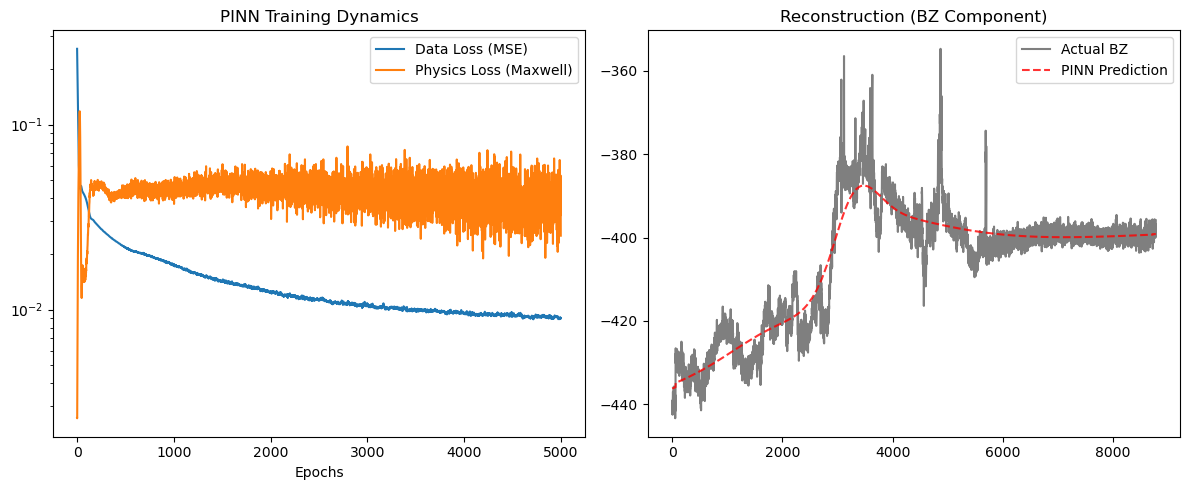

PINN Model saved.


In [6]:

# ==========================================
# 5. Results & Saving
# ==========================================
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(loss_history['data'], label='Data Loss (MSE)')
plt.plot(loss_history['physics'], label='Physics Loss (Maxwell)')
plt.yscale('log')
plt.title('PINN Training Dynamics')
plt.xlabel('Epochs')
plt.legend()

# Prediction Plot
model.eval()
with torch.no_grad():
    full_pred_scaled = model(X_tensor)
    full_pred = output_scaler.inverse_transform(full_pred_scaled.numpy())

plt.subplot(1, 2, 2)
plt.plot(y_raw[:, 2], 'k-', alpha=0.5, label='Actual BZ')
plt.plot(full_pred[:, 2], 'r--', alpha=0.8, label='PINN Prediction')
plt.title('Reconstruction (BZ Component)')
plt.legend()

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), 'europa_pinn_model.pth')
print("PINN Model saved.")